/tmp/ipykernel_7610/646473105.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = pd.to_datetime(data['id'], errors='ignore')
/tmp/ipykernel_7610/646473105.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))


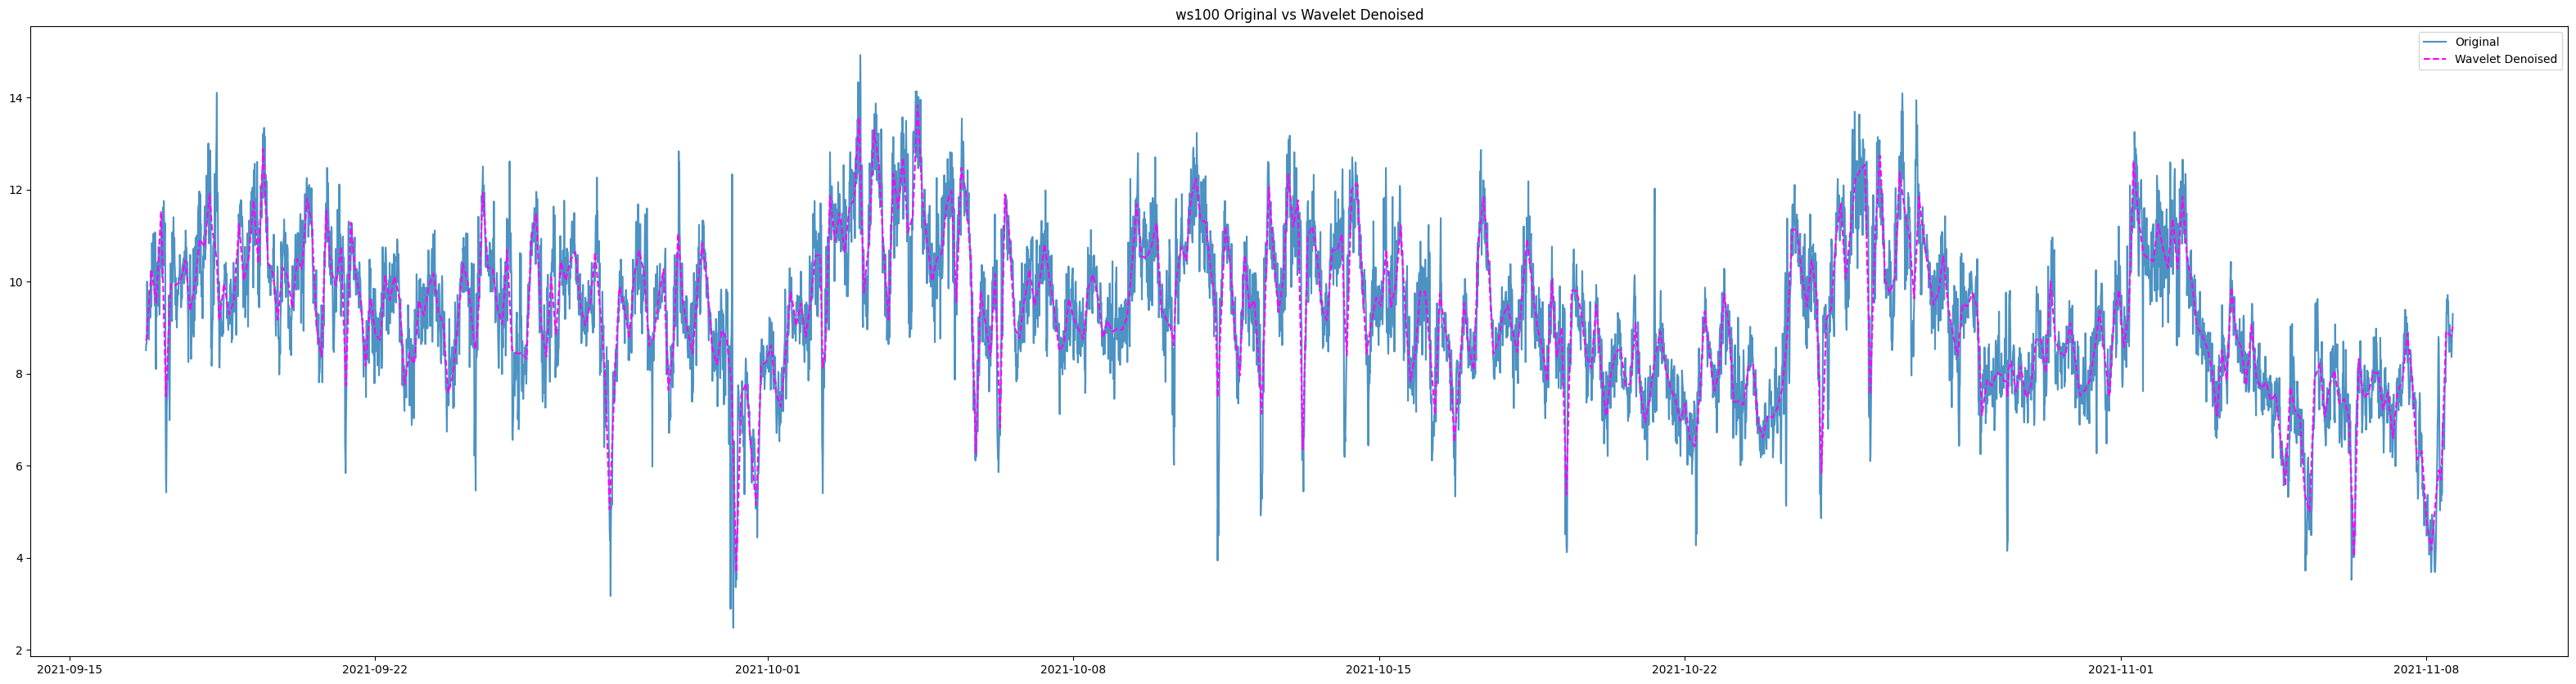

In [8]:
# %% Importação das Bibliotecas Necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pywt  # Biblioteca para Wavelet Transform
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, Bidirectional, LSTM, LayerNormalization, RepeatVector, Dense, Concatenate, TimeDistributed, Lambda, Conv1D, MaxPooling1D, Dropout, Add

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import shutil
import os


# %% Leitura e Preparação dos Dados
data = pd.read_csv("dataset.csv")
data.index = pd.to_datetime(data['id'], errors='ignore')
data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))

variables = pd.DataFrame(index=data.index)

# Função para Suavização usando Wavelet Transform
def wavelet_denoising(signal, wavelet='bior2.2', level=4):
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='symmetric')
    return reconstructed_signal

# Aplicação do Wavelet Denoising às Colunas Desejadas
for col in ['ws100', 'humid', 'wdisp100', 'wdir100']:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal[:len(data)]  # Garantir que o tamanho seja consistente
    else:
        raise ValueError(f"A coluna {col} não existe no dataset.")
    
    # Plotagem para Comparação
plt.figure(figsize=(40, 10))
plt.plot(data.index, data['ws100'], label='Original', alpha=0.8)
plt.plot(variables.index, variables['ws100_wavelet'], label='Wavelet Denoised', linestyle='--', color='magenta')
plt.title('ws100 Original vs Wavelet Denoised')
plt.legend()
plt.show()

# Escalonamento dos Dados
scaler_ws100 = MinMaxScaler()
variables_scaled_ws100 = scaler_ws100.fit_transform(variables[['ws100_wavelet']])

scaler_other = MinMaxScaler()
variables_scaled_other = scaler_other.fit_transform(variables.drop(columns=['ws100_wavelet']))

variables_scaled = np.hstack((variables_scaled_ws100, variables_scaled_other))
variables_scaled = pd.DataFrame(
    variables_scaled, 
    columns=variables.columns, 
    index=variables.index
)



Valor calculado de delta (80th percentile): 0.1858479190652741


Model: "Bidirectional_LSTM_Seq2Seq_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 36, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 36, 128)   │     35,328 │ encoder_inputs[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm_0      │ (None, 36, 128)   │        256 │ bidirectional_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 36, 128)   │          0 │ encoder_norm_0[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128)       │          0 │ dropout_14[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 6, 128)    │          0 │ get_item_4[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_0      │ (None, 6, 128)    │    131,584 │ repeat_vector_4[… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_norm_0      │ (None, 6, 128)    │        256 │ decoder_lstm_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 6, 128)    │          0 │ decoder_norm_0[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attention │ (None, 6, 128)    │    197,888 │ dropout_14[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_15[0][0], │
│                     │                   │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 6, 64)     │      8,256 │ multihead_attent… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 6, 192)    │          0 │ dropout_15[0][0], │
│ (Concatenate)       │                   │            │ attention_dense[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 1)      │        193 │ concatenate_6[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 6)         │          0 │ output_layer[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 373,761 (1.43 MB)

 Trainable params: 373,761 (1.43 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento da execução 1/1
Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0582 - mae: 0.3792 - val_loss: 0.0056 - val_mae: 0.0535 - learning_rate: 1.0000e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0225 - mae: 0.1725 - val_loss: 0.0073 - val_mae: 0.0729 - learning_rate: 1.0000e-04
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0141 - mae: 0.1186 - val_loss: 0.0053 - val_mae: 0.0417 - learning_rate: 1.0000e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0087 - mae: 0.0797 - val_loss: 0.0047 - val_mae: 0.0378 - learning_rate: 1.0000e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0062 - mae: 0.0581 - val_loss: 0.0040 - val_mae: 0.0320 - learning_rate: 1.0000e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0054 - mae: 0.0536 - val_loss: 0.0040 - val_mae: 0.0363 - learning_rate: 1.0000e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0049 

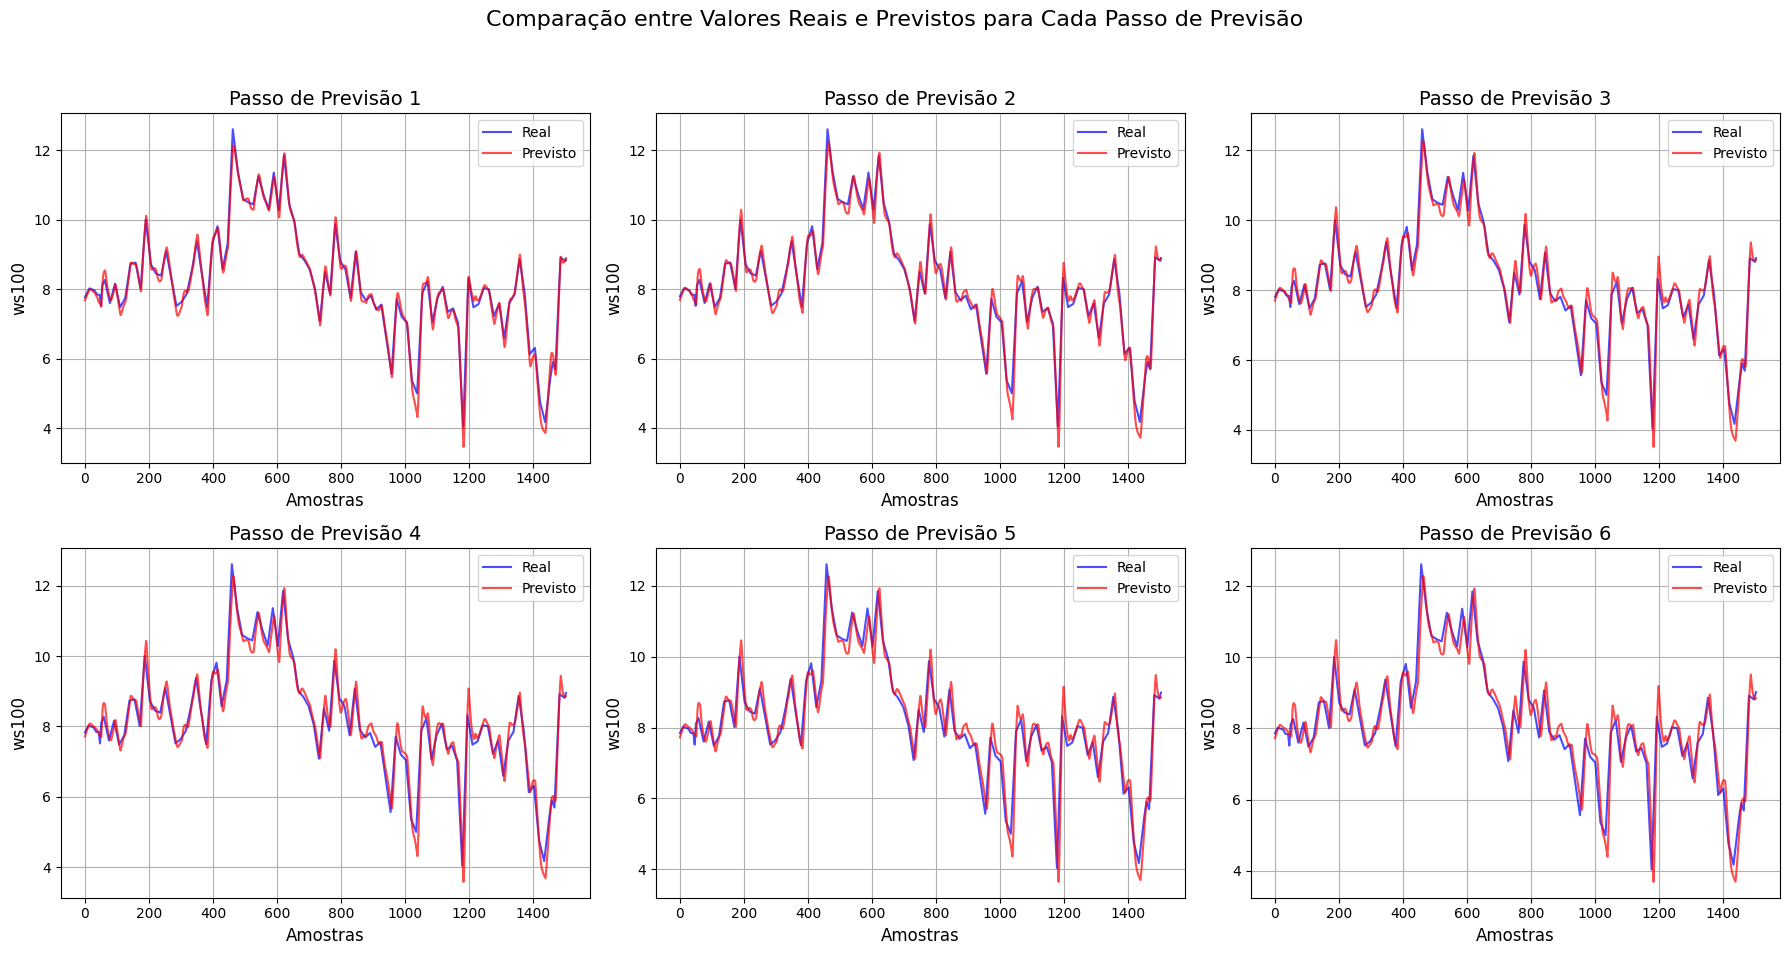

In [ ]:
# %% Preparação dos Dados para o Modelo
input_steps = 36
output_steps = 6

def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps)])
        y.append(data[(i + input_steps):(i + input_steps + output_steps), 0])  
    return np.array(X), np.array(y)

data_array = variables_scaled.values

X, y = create_sequences(data_array, input_steps, output_steps)

split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Flatten the scaled ws100 values
ws100_values = variables_scaled_ws100.flatten()

# Calculate absolute deviations from the mean
abs_deviation = np.abs(ws100_values - np.mean(ws100_values))

# Find the 80th percentile value
delta = np.percentile(abs_deviation, 80)

print(f"Valor calculado de delta (80th percentile): {delta}")


def custom_huber_loss(y_true, y_pred):
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
    return loss

def custom_huber_loss_inverted(y_true, y_pred):
    error = y_true - y_pred
    abs_error = tf.abs(error)
    # Apply quadratic loss when error is greater than delta
    quadratic = tf.maximum(abs_error - delta, 0)
    # Apply linear loss when error is less than or equal to delta
    linear = tf.minimum(abs_error, delta)
    loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
    return loss


def build_model(input_steps, num_features, output_steps):
    num_layers = 1
    units = 64  # Base units for LSTM layers
    attention_units = units * 2  # Output dimension after LSTM layers
    dropout_rate = 0.1
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    # Encoder
    encoder_inputs = Input(shape=(input_steps, num_features), name='encoder_inputs')
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        encoder_outputs = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            kernel_regularizer=l2(1e-6),
            activity_regularizer=l2(1e-6),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        encoder_outputs = LayerNormalization(name=f'encoder_norm_{i}')(encoder_outputs)
        if dropout_rate > 0:
                encoder_outputs = tf.keras.layers.Dropout(dropout_rate)(encoder_outputs)
    # Context from the encoder outputs
    context_vector = encoder_outputs  # Encoder outputs for attention
    
    # Decoder
    decoder_inputs = RepeatVector(output_steps)(encoder_outputs[:, -1, :])  # Use the last time step of the encoder
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_outputs = LSTM(
            units=attention_units,  # Units doubled for decoder
            return_sequences=True,
            kernel_regularizer=l2(1e-6),
            activity_regularizer=l2(1e-6),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_outputs = LayerNormalization(name=f'decoder_norm_{i}')(decoder_outputs)
    if dropout_rate > 0:
            decoder_outputs = tf.keras.layers.Dropout(dropout_rate)(decoder_outputs)
    # Self-Attention on Decoder Outputs
    self_attention_layer = MultiHeadAttention(num_heads=6, key_dim=32, name='self_attention')
    self_attention_output = self_attention_layer(query=decoder_outputs, value=decoder_outputs, key=decoder_outputs)
    
    # Encoder-Decoder Attention
    enc_dec_attention_layer = MultiHeadAttention(num_heads=6, key_dim=32, name='enc_dec_attention')
    enc_dec_attention_output = enc_dec_attention_layer(query=decoder_outputs, value=context_vector, key=context_vector)
    
    # Combine Attention Outputs
    combined_attention = Concatenate(axis=-1)([enc_dec_attention_output, self_attention_output])
    
    # Adjust the Combined Attention Output
    attention_dense = Dense(attention_units, activation='tanh', name='attention_dense')
    attention_output = attention_dense(combined_attention)
    
    # Combine with Decoder Outputs
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    # Output Layer
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined_context)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(outputs)  # Shape: [batch, output_steps]
    
    # Model Definition
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_Seq2Seq_with_Attention')
    
    # Compiling the Model with the Custom Huber Loss Function
    model.compile(
        optimizer=optimizer,
        loss=custom_huber_loss,
        metrics=['mae']
    )
    
    return model

def build_model_2(input_steps, num_features, output_steps):
    num_layers = 1
    units = 64
    dropout_rate = 0.1

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    # Encoder
    encoder_inputs = Input(shape=(input_steps, num_features), name='encoder_inputs')
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        encoder_outputs = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            kernel_regularizer=l2(1e-6),
            activity_regularizer=l2(1e-6),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        encoder_outputs = LayerNormalization(name=f'encoder_norm_{i}')(encoder_outputs)
        if dropout_rate > 0:
                encoder_outputs = tf.keras.layers.Dropout(dropout_rate)(encoder_outputs)
    # Contexto de Atenção
    context_vector = encoder_outputs  # Saídas do encoder para a atenção
    
    # Decoder
    decoder_inputs = RepeatVector(output_steps)(encoder_outputs[:, -1, :])  # Usar o último passo do encoder
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_outputs = LSTM(
            units=units * 2,
            return_sequences=True,
            kernel_regularizer=l2(1e-6),
            activity_regularizer=l2(1e-6),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_outputs = LayerNormalization(name=f'decoder_norm_{i}')(decoder_outputs)
        if dropout_rate > 0:
            decoder_outputs = tf.keras.layers.Dropout(dropout_rate)(decoder_outputs)
    # Aplicar Atenção
    # Atenção Multi-Head
    attention_layer = MultiHeadAttention(num_heads=6, key_dim=units, name='multihead_attention')
    attention_output = attention_layer(query=decoder_outputs, value=context_vector, key=context_vector)

    # Ajustar o Contexto da Atenção com uma Camada Dense
    attention_dense = Dense(units, activation='tanh', name='attention_dense')
    attention_output = attention_dense(attention_output)

    # Combinar com o Decoder
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    # Camada de Saída
    # Alteração: Usar TimeDistributed com Dense(1) e remover dimensões extras
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined_context)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(outputs)  # [batch, output_steps]
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_Seq2Seq_with_Attention')
    
    # Compilação do Modelo com a Função de Perda Customizada
    model.compile(
        optimizer=optimizer,
        loss=custom_huber_loss,
        metrics=['mae']
    )
    
    return model

num_runs = 1

# %% Construção e Treinamento do Modelo
num_features = X_train.shape[2]
model = build_model_2(input_steps, num_features, output_steps)

model.summary()

best_val_loss = float('inf')
best_model_path = 'best_model.h5.keras'


for run in range(1, num_runs + 1):
    print(f"\nIniciando o treinamento da execução {run}/{num_runs}")
    
    # Construir um novo modelo para cada execução
    model = build_model(input_steps, num_features, output_steps)
    
    # Definir um caminho único para o checkpoint temporário desta execução
    temp_checkpoint = f'best_model_run{run}.h5.keras'
    
    # Definir os callbacks para esta execução
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(temp_checkpoint, monitor='val_loss', save_best_only=True)
    ]
    
    # Treinar o modelo
    history = model.fit(
        X_train, y_train, 
        epochs=100,  
        batch_size=32, 
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    
    # Obter o melhor val_loss desta execução
    run_best_val_loss = min(history.history['val_loss'])
    print(f"Melhor val_loss na execução {run}: {run_best_val_loss}")
    
    # Comparar com o melhor val_loss global
    if run_best_val_loss < best_val_loss:
        print(f"A execução {run} melhorou o val_loss global. Salvando o modelo como o melhor.")
        best_val_loss = run_best_val_loss
        shutil.copyfile(temp_checkpoint, best_model_path)
    else:
        print(f"A execução {run} não melhorou o val_loss global.")
    
    # Remover o checkpoint temporário desta execução
    os.remove(temp_checkpoint)

print(f"\nTreinamento completo. Melhor val_loss alcançado: {best_val_loss}")

# Carregar os pesos do melhor modelo encontrado
model.load_weights(best_model_path)

y_pred = model.predict(X_test)

y_test_inversed = scaler_ws100.inverse_transform(y_test)
y_pred_inversed = scaler_ws100.inverse_transform(y_pred)

# %% Visualização dos Resultados
output_steps = 6

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparação entre Valores Reais e Previstos para Cada Passo de Previsão', fontsize=16)

for step in range(output_steps):
    row = step // 3
    col = step % 3
    ax = axes[row, col]
    
    real = y_test_inversed[:, step]
    pred = y_pred_inversed[:, step]
    
    ax.plot(real, label='Real', color='blue', alpha=0.7)
    ax.plot(pred, label='Previsto', color='red', alpha=0.7)
    
    ax.set_title(f'Passo de Previsão {step + 1}', fontsize=14)
    ax.set_xlabel('Amostras', fontsize=12)
    ax.set_ylabel('ws100', fontsize=12)
    ax.legend()
    ax.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()